<h1>Event Study: Cybersecurity Breaches Effects on Stock Price</h1>

<h2>Introduction</h2>
<h3>Some Background</h3>
Most literature regarding financial forecasts of a company's future stock price does not include recent cybersecurity breaches as a key factor to take into consideration. Many studies looking at the economic effects of cybersecurity breaches on companies support this reasoning by showing that cybersecurity breaches have relatively <a href="https://meridian.allenpress.com/jis/article-abstract/33/3/227/10584/Much-Ado-about-Nothing-The-Lack-of-Economic-Impact">small economic consequences</a>. With the little effect cybersecurity breaches have on future performances, stock prices are able to rebound to their levels before the breach, with supposedly <a href= "http://web.csulb.edu/colleges/cba/intranet/vita/pdfsubmissions/26629-jis19-much-ado-about-nothing.pdf">no long term changes</a>. However, there is <a href= "https://www.researchgate.net/publication/336947778_The_Impact_of_Reported_Cybersecurity_Breaches_on_Firm_Innovation">research</a> suggesting that there are other long-term consequences like decline in firm productivity, research and development spending, patents, and investment efficiency.

<h3>What are we doing and why?</h3>
It seems that there is differing information on the long-term effects of cybersecurity breaches on companies. Through this project, we would like to see what the long-term effects of cybersecurity breaches on company stock truly are. Hopefully, we can show that cybersecurity breaches do have lasting consequences to show that it is important to consider breach disclosure in predictive financial models. If we were to prove this, we could bolster better cybersecurity efforts and funding.

<h3>How will we do this?</h3>
We will confirm, through an event-study, that cybersecurity breach disclosure has a short-term impact on company stock price. We then shift our focus to the long-term by analyzing the differences between financial analysts’ predictions and actual stock prices a year after breach disclosure. In this long-term analysis, we hope to find a difference between financial analysts predictions and actual stock prices as to prove that predictive financial models are lacking, which hints that they should be considering cybersecurity breaches as important in long-term predictions for stock price.

<h2>Set Up</h2>
This will all be done using <a href="https://www.wikiwand.com/en/Python_(programming_language)">Python</a>, leveraging <a href= "https://jupyter.org/">Jupyter Notebooks</a> to visualize various plots, graphs and tables. Here some useful information to install these tools: <a href="https://conda.io/projects/conda/en/latest/user-guide/install/index.html">1</a>, <a href="https://conda.io/projects/conda/en/latest/user-guide/getting-started.html">2</a>, <a href="https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html">3</a>, <a href="https://www.youtube.com/watch?v=HW29067qVWk">4</a>. 

Below are the packages we will use to collect and visualize our data.

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 
# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

# Data Collection
# os.system("pip install wrds") 
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web

<h2>Data Collection</h2> 

We will be using the <a href= "https://wrds-www.wharton.upenn.edu/">WRDS</a> (Wharton Research Data Services) database to find financial analyst predictions on stock price using their <a href= "https://www.investopedia.com/terms/i/ibes.asp">IBES</a> dataset. The WRDS database is provided to all UMD staff and students for free, you can sign up for an account <a href="https://wrds-www.wharton.upenn.edu/register/">here</a>. When running this following section of code, you must supply your account's credentials. We recommend setting up a <a href = "https://matteocourthoud.github.io/post/wrds/"> pgpass</a> to help automate the process.

In [2]:
db = wrds.Connection()

Enter your WRDS username [gabri]:gnaval
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


We will be using the Audit Analytics February 2021 issue of cybersecurity databreaches. To get this dataset, we contacted the University of Maryland's Smith Business School, which provided this Excel file to us. <a href = "https://www.auditanalytics.com/">Audit Analytics</a> is an organization that tracks relevant business and financial data such as the information of a company cybersecurity breach. 

We will now load in the data by accessing the correct Excel sheet. 

In [3]:
# Audit Analytics Dataset
xls = pd.ExcelFile('../data/audit_analytics.xlsx')
aa_records_df = pd.read_excel(xls, 'PublicCyber')

Each row in this dataset represents a company's cybersecurity breach. The dataset contains useful information such as the company breached, date of public disclosure of the breach, and other varying information about the company and the type of cybersecurity breach performed. 

To clean the data, we need to drop all the rows that don't contain any company tickers. <a href ="https://www.wikiwand.com/en/Ticker_symbol">Tickers</a>, consisting of numbers and letters, are short abbreviations uniquely identifying a publicly traded company (Ex: Amazon is uniquely identified by their ticker, AMZN). If a row doesn't have a ticker symbol, then there may have been data corruption, human errors logging the data, or the company may not be publicly traded. Either way, we need to remove the rows. We also extract the relevant columns for our analysis (as shown in the table_columns array). Once this is all done, it leaves us with a dataset of 737 cybersecurity breaches on publicly traded companies.

In [ ]:
# Data Cleaning
aa_records_df = aa_records_df[aa_records_df['Ticker'].isna() != True].reset_index(drop=True)
table_columns = ['Company name', 'Ticker', 'Date of Breach', 'Date Became Aware of Breach', 'Date of Disclosure',
                 'Number of Records', 'Type of Info', 'Information', 'Attack', 'Region', 'SIC Code']
aa_records_df = aa_records_df[aa_records_df.columns.intersection(table_columns)]

Now, let's try to find the monthly stock price of each of these firms following the disclosure of the breach.

Before we do that, we define a short helper function that will help us find the closest date in a set that corresponds to X months after the disclosure of a breach. We will make use of this utility in our main function for finding monthly stock prices.

In [ ]:
def nearest(items, pivot):
    """
    Gets closest day in a set (used to obtain stock price X months after disclosure)
    """
    return min(items, key=lambda x: abs((x - pivot).days))

With that out of the way, let's construct a function to obtain the monthly stock prices after the disclosure of the data breach. Let's break it down! 

Our function has two parameters: a row from our original breach dataframe and the number of months to get stock prices from. First, our function determines the range of dates to obtain monthly stock prices. Please note that our starting date is a day before the disclosure breach as to control for any fluctuations in stock price due to that disclosure. Following this, we leverage <a href="https://pandas-datareader.readthedocs.io/en/latest/index.html">pandas_datareader</a>, an <a href="https://rapidapi.com/blog/api-glossary/api-wrapper/#:~:text=In%20that%20line%2C%20an%20API,to%20automate%20API%2Dreliant%20processes.">API wrapper</a> for various API's. Specifically, we will be using its <a href = "https://finance.yahoo.com/">YahooFinance</a> API functionality, which will provide us with a dataframe of stock prices (df) beginning at our start date and ending at our end date. We then traverse through this dataframe, using our nearest helper function, to obtain the monthly stock prices and return them as an array. 

If the YahooFinance API cannot find a company's stock price for whatever reason, it returns an array of np.nan's. Likewise, if 
no stock price is available for a month because it's missing or because that month's date lies in the future and hasn't occurred yet, then the array will be populated by np.nan's for those months.

Note: We record the <a href = "https://finance.zacks.com/significance-closing-price-stock-3007.html">closing</a> stock prices, meaning its the stock price at the end of a day. <br>
Note: The YahooFinance API has a limit of 2,000 requests per hour. As we only have 737 breaches, we won't be hitting that limit, but keep that in mind when using API's.

In [5]:
today = datetime.datetime.today().date()

def stock_after_disclosure(row, num_months):
    """
    Returns an array containing the monthly stock price of a firm after date of disclosure (0 - num_months months after breach).
    If firm exists in YahooFinance database, but no stock price available for a month (either b/c that date has yet to occur 
    or b/c simply N/A),
    returns np.nan.
    If firm does not exist in YahooFinance database, return array of np.nan's.
    
    Parameters: 
    row : Dataframe row
        Input dataframe's row (used along with df.apply)
    num_months : int
        Month limit
    """
    start = pd.to_datetime(row['Date of Disclosure']) 
    end = start + pd.DateOffset(months = num_months)
    start -= datetime.timedelta(days=1) 
    try:
        df = web.DataReader(row['Ticker'], 'yahoo', start, end)
        lst = []
        for month in range(0, num_months + 1):
            if today <= (start + pd.DateOffset(months = month)).date():
                for x in range(month, num_months + 1):
                    lst.append(np.nan)
                break
            date = nearest(df.index, (start + pd.DateOffset(months = month)))
            lst.append(df.loc[date]["Close"])
        return lst
    except Exception as e:
        print("Error at %s" % row['Ticker'])
        print(repr(e))
        return [np.nan] * (num_months + 1)

Let's run our function on each row in our dataset. We'll be finding the monthly stock prices spanning a year after the disclosure of the breach. 

Note: This section of code takes a while to run (20-30 minutes) because we will be making API requests, loading in data from a server, and performing operations on said data.

In [ ]:
lst = []
months_after = 12 #Toggle this value
col = []
# Set the column names for new dataframe
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

# Create array of arrays that contains stock prices after date of disclosure for each breach
for index, row in aa_records_df.iterrows():
    x = stock_after_disclosure(row, months_after)
    lst.append(x)

Following this, we can concatenate said data to our original dataframe.

In [ ]:
# Merge stock price after breach with original dataframe
stock_prices = pd.DataFrame(lst, columns = col)
stock_price_aa_records = pd.concat([aa_records_df, stock_prices], axis=1, join='inner')

We now have the actual stock prices. Let's move on to finding analyst predictions for these companies. 

We define the function below to find the analyst stock price predictions. It makes use of the <a href="https://www.investopedia.com/terms/i/ibes.asp">IBES</a> database in WRDS. The function takes all the financial analyst predictions within a month of the disclosure of the breach that forecast the company's stock price a year into the future. Since multiple financial analysts may make predictions, this function returns the median and mean of these predictions. If no predictions are found, the function returns np.nan's. 

Note: This function makes use of SQL, a programming language used to communicate with databases. Here are some helpful resources to get started learning about SQL: <a href = "https://www.codecademy.com/learn/learn-sql">CodeAcademy</a>, <a href = "https://www.khanacademy.org/computing/computer-programming/sql">KhanAcademy</a>

In [15]:
def analyst_stock_price(row):
    """
    Returns the median and mean of analyst stock price forecasts for a firm, where the forecasts are within a month after the beach. 
    These forecasts predict the stock price 12 months into the future.
    
    Parameters
        row - Dataframe row
        Input dataframe's row (used along with df.apply)
    Returns
        List of length 2. [median, mean]
    """
    date = pd.to_datetime(row['Date of Disclosure'])
    
    sql_query="""
    SELECT VALUE as stock_price
    FROM ibes.ptgdet
    WHERE OFTIC ='{}' AND CAST(HORIZON as int) = 12 AND ANNDATS BETWEEN '{}' and '{}'
    """.format(row['Ticker'], date, date + pd.DateOffset(months = 1))
    
    df = db.raw_sql(sql_query)
    
    if len(df.index) == 0:
        return [np.nan] * 2
    return [df['stock_price'].median(), df['stock_price'].mean()]
    

We can now run the function on each company to get the financial analyst forecasts.

In [ ]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
lst = []
for index, row in stock_price_aa_records.iterrows():
    lst.append(analyst_stock_price(row))
    
# Merge stock price after breach with original dataframe
median_mean_df = pd.DataFrame(lst, columns = ['median stock forecast', 'mean stock forecast'])
stock_price_aa_records = pd.concat([stock_price_aa_records, median_mean_df], axis=1, join='inner')

Nice! We have now collected all the data to compare actual stock prices with financial analyst predicted stock prices. But before we do some Exploratory Data Analysis (EDA), we need to do...

<h2>Data Transformation and Management</h2> 

As it turns out, we might want to transform some of our data relating to stock prices because of innate variation between companies. 

To better understand this problem, consider this hypothetical: Suppose company A's and company B's stock price both double after a year. However, company A's initial stock was much smaller, say it started at \\$10 and became \\$20 per share, while company B's stock went from \\$100 to \\$200 per share. Their numerical growth are rather different, but their percent growth are the same. When comparing growth between companies, it makes more sense to compare percent growth since it will better control for the already established stock of that company (whether that be high or low). In a way, finding the percent growth is like standardizing each company's current stock price by their initial stock price.

For that reason, we need to be looking at percent stock price change for these companies, where the initial stock price corresponds to the stock price the day of the disclosure for the breach. The code below transforms the data to percent stock price change for the actual and predicted stock prices.

In [26]:
stock_prices = pd.DataFrame()
n = 1 
for x in col[1:]:
    stock_prices[n] = stock_price_aa_records.apply(lambda row: (row[x] - row[col[0]])/row[col[0]], axis = 1)
    n += 1
    
t1 = stock_price_aa_records.apply(lambda row: (row['median stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)
t2 = stock_price_aa_records.apply(lambda row: (row['mean stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)

analysts_percent = pd.concat([stock_prices[12], pd.DataFrame(t1), pd.DataFrame(t2)], axis=1, join='inner')
analysts_percent.columns = ['Actual', 'Analyst Median', 'Analyst Mean']

<h2>Exploratory Data Analysis</h2>

To begin, let's make some boxplots and violin plots to get a better understanding of how actual stock prices change over time. We will be making use of the <a href="https://seaborn.pydata.org/index.html">seaborn</a> Python library. We also make use of <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html">melting</a> (more info <a href="http://www.jeannicholashould.com/tidy-data-in-python.html">here</a>).

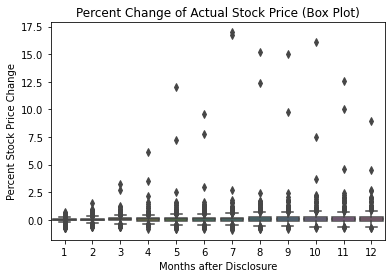

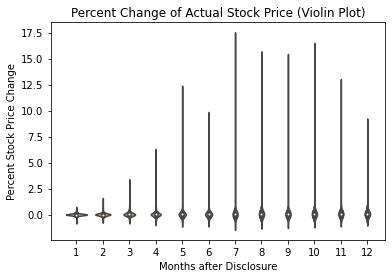

In [28]:
boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(stock_prices).dropna())
boxplot.set(xlabel="Months after Disclosure", ylabel='Percent Stock Price Change') 
boxplot.set_title("Percent Change of Actual Stock Price (Box Plot)")
plt.show()

ax = sns.violinplot(x='variable', y='value', data=pd.melt(stock_prices).dropna())

plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
ax.set_title("Percent Change of Actual Stock Price (Violin Plot)")
ax.plot()
plt.show()

Well...these plots don't really help but why? It seems that there are some major outliers that are making it hard to see how the percent change of actual stock price shifts over time. We have two options here: <a name="two_options"></a>
1. Remove the outliers and re-plot the data.
2. Find a better metric to represent these distributions over time.

Let's opt to do the second option. There are other metrics to represent these distributions, namely seeing how the "middle" of these distributions change over time. We can define the "middle" of each of these distributions to be the mean or median stock price percent change over time. 

Let's take the naive approach of plotting the mean over time.

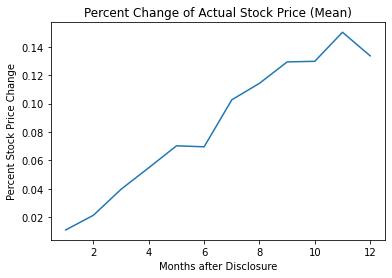

In [29]:
plt.plot(np.arange(1, 13), stock_prices.mean())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Mean)")
plt.show()

It seems like the mean trends upwards over time. This is to say that over time, after public disclosure of a breach, the stock price of companies tend to still trend upwards. It seems that public disclosure of a breach might not have long-term consequences to a company's stock price. 

But wait! Let's not forget:
> <i>"There are three kinds of lies: lies, damned lies, and <b>statistics</b>."</i>
> \- Mark Twain

Means are only good representations of the "middle" of a distribution given that there are <a href = "https://statistics.laerd.com/statistical-guides/measures-central-tendency-mean-mode-median.php#:~:text=When%20not%20to%20use%20the%20mean">no influential outliers and no skewness</a>. A better way of representing the "middle" would be to use the median, which is less affected by outliers and skewness. Let's plot the medians.

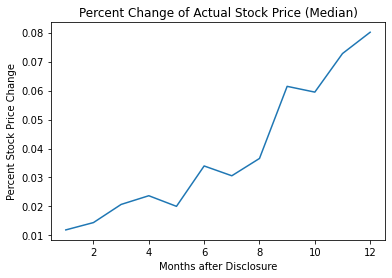

In [30]:
plt.plot(np.arange(1, 13), stock_prices.median())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Median)")
plt.show()

It seems like when we plot the median over time, the same trend occurs, <b>but</b> it's important to note that the percent stock price percent change values are not as large as the plot of means. Even more important is that the trend no longer seems exactly linear. It seems like the stock price grows slowly at the beginning and then gradually increases later on. This could be representative of a company recovering from the public disclosure of the breach at the start (which causes less stock gains) but after a while the company's growth goes back to normal. We'll look more into the details of this when we perform the event study.

Another way of representing the "middle" is to take the <a href="https://www.investopedia.com/terms/t/trimmed_mean.asp">trimmed mean</a> to get rid of outliers. Below, we took the 5% trimmed means and plotted them. It looks to have the similar trends and observations as the plot of medians.

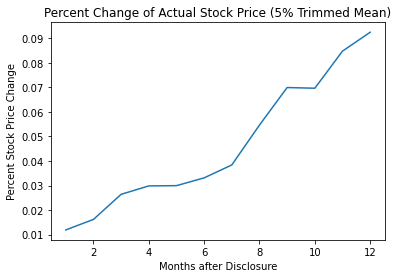

In [31]:
# Let's take 5% trimmed mean (get rid of some outliers)
trimmed_means = []
for x in range(1, months_after + 1):
    trimmed_means.append(stats.trim_mean(stock_prices[x].dropna(), 0.05))
plt.plot(np.arange(1, 13), trimmed_means)
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (5% Trimmed Mean)")
plt.show()    

Let's now compare the actual versus financial analyst predictions of the stock price a year after the public disclosure of a cybersecurity breach. We will do this through a violin plot.

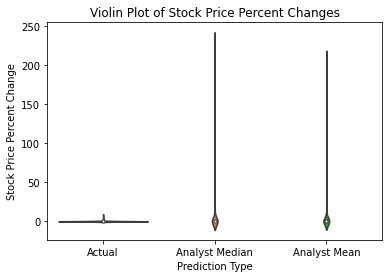

In [33]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Actual', 'Analyst Median', 'Analyst Mean']]).dropna())
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change')
violinplot.set_title("Violin Plot of Stock Price Percent Changes")
plt.show()

Once again, there appears to be some outliers for these distributions, specifically for financial analyst predictions. As mentioned [before](#two_options), there are two options for handling these outliers. We don't really want to use a new metric like the "middle" because we want to compare the actual distributions, so we will instead opt for option one and remove the outliers. 

We will be removing the outliers for the financial analyst median and mean predictions. To remove the outliers, we need some rule to label something as an outlier. There are different methods for classifying outliers, but we opt to abide by the <a href="https://www.wikiwand.com/en/68%E2%80%9395%E2%80%9399.7_rule">three-sigma rule</a>, which states that nearly all values are taken to lie within three <a href= "https://www.wikiwand.com/en/Standard_deviation">standard deviations</a> of the mean. If a point were to be beyond three standard deviations from the mean, then we will classify that point as an outlier and remove it from the distribution. The following creates distributions without these outliers.

In [34]:
z_scores = stats.zscore(analysts_percent['Analyst Median'].dropna())

abs_z_scores = np.abs(z_scores)
medians_no_outliers = analysts_percent['Analyst Median'].dropna()[abs_z_scores < 3]

z_scores = stats.zscore(analysts_percent['Analyst Mean'].dropna())

abs_z_scores = np.abs(z_scores)
means_no_outliers = analysts_percent['Analyst Mean'].dropna()[abs_z_scores < 3]

Let's now create a new violin plot without the outliers.

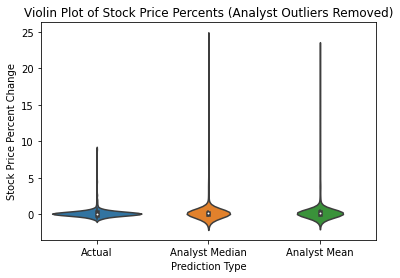

In [36]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([analysts_percent['Actual'],medians_no_outliers, means_no_outliers], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') 
violinplot.set_title("Violin Plot of Stock Price Percents (Analyst Outliers Removed)")
plt.show()

This violin plot is way more legible than the previous. It seems from this violin plot that the financial analyst predictions tend to vary more than the actual stock prices. It also hints that financial analysts tend to overestimate the actual stock price of these companies. A better method of visualizing these differences is to look at the residuals of these stock prices, where the residual is the actual minus the predicted stock price percent change.

The following code will compute the residuals for each prediction type and plot them. Note that for this part, the outlier financial analyst predictions have been kept.

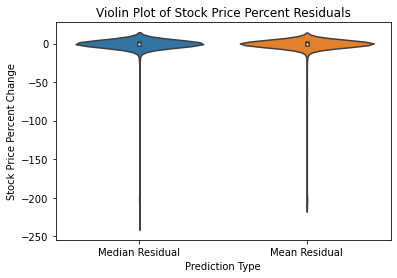

In [38]:
analysts_percent['Median Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Median"], axis =1)
analysts_percent['Mean Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Mean"], axis =1)

violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Median Residual', 'Mean Residual']]))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') 
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

It seems the distribution of these different residuals appear very similar. It also appears that these distributions center around 0 but are skewed towards the negative end. For this to happen, it means that financial analyst predictions are greater than the actual stock prices. 

For a better look, here's a display the summary statistics for each residual distribution. I would like to note that our initial sample of cybersecurity breaches was 737, but it has now shrunk down to a set of 474 breaches. This could either be due to the Yahoo Finance API not containing stock prices for certain companies, IBES not having predictions for smaller companies, or a year hasn't elapsed since the public disclosure of the cybersecurity breach.

In [39]:
print(analysts_percent['Median Residual'].describe())
print()
print(analysts_percent['Mean Residual'].describe())

count    476.000000
mean      -1.758415
std       17.179386
min     -231.820000
25%       -0.278717
50%       -0.033483
75%        0.189021
max        4.721649
Name: Median Residual, dtype: float64

count    476.000000
mean      -1.703157
std       16.497254
min     -208.660000
25%       -0.285764
50%       -0.028402
75%        0.193967
max        4.721649
Name: Mean Residual, dtype: float64


It does seem that financial analysts overestimate the actual stock prices for these firms that had recently issued public disclosures of cybersecurity breaches. We need a to perform a more scientific/mathematical study to conclude this. This takes us to our next section...

<h2>Hypothesis Testing</h2>

We want to perform a statistical test to confirm our findings that the financial analysts overestimate the actual stock price. Specifically, we want a test that proves that these residuals we've found skew towards negative. In other words, we want to prove that the mean ($\mu$) of the distribution of residuals is negative and that these results are statistically significant, meaning there is little to no doubt that the mean is 0.

The best test for this situation would be a 1-sample t-test, specifically a <a href= "https://www.statisticssolutions.com/manova-analysis-paired-sample-t-test/#:~:text=The%20paired%20sample%20t%2Dtest,resulting%20in%20pairs%20of%20observations.">paired sample t-test</a>. To get an understanding of how this test works, we need to understand what a <a href = "https://support.minitab.com/en-us/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/basics/null-and-alternative-hypotheses">null and alternative hypothesis</a> are. The null hypothesis states that a population parameter is equal to a hypothesized value. The alternative hypothesis states that a population parameter is different from the hypothesized value posited in the null hypothesis. These two hypotheses are mutually exclusive (if one is true, the other is false). In this case, our hypotheses are:

- Null Hypothesis: 		$\mu = 0$
- Alternative Hypothesis:	$\mu < 0$

The null hypothesis roughly translates to the mean of the distribution of residuals is equal to 0, meaning that we expect no difference between the actual and predicted stock prices. The alternative hypothesis roughly translates to the mean of the distribution of residuals is less than 0, meaning that the predicted stock prices tend to be greater than the actual stock prices. 

In this statistical test, we begin with assuming the null hypothesis is true. We then study our sample dataset (through statistical methods) to see if given the null hypothesis is true, the sample dataset could reasonably occur. If our data could not reasonably happen under the premise of the null hypothesis, then we reject the null hypothesis and assume it's false. Since the null hypothesis is false in these circumstances, we would have to accept the alternative hypothesis as true. In the case that the data is not significantly opposed to the premise of the null hypothesis, we fail to reject the null hypothesis - meaning we have no evidence to believe its contrary. This is the essence of most statistical hypothesis testing. For a more through explanation, click <a href= "https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/">here</a>.

Before we can perform this test, we need to meet certain prerequisites. We need to meet the three assumptions: independence of observations, approximately normal distributions, and no major outliers. We can reasonably assume independence of observations since one company’s residual does not affect another’s. From the violin plot, it seems that the distribution is approximately normal and to meet the assumption of no major outliers, we will remove outliers from the dataset when performing the test. Depicted below is a violin plot of the residuals with major outliers removed.

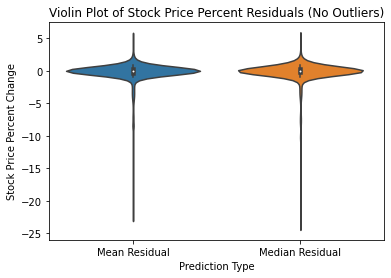

In [43]:
z_scores = stats.zscore(analysts_percent['Median Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_median = analysts_percent['Median Residual'].dropna()[abs_z_scores < 3]

z_scores = stats.zscore(analysts_percent['Mean Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_mean = analysts_percent['Mean Residual'].dropna()[abs_z_scores < 3]

violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([no_outliers_mean, no_outliers_median], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') 
violinplot.set_title("Violin Plot of Stock Price Percent Residuals (No Outliers)")
plt.show()

We also have to establish a <a href="https://blog.minitab.com/en/adventures-in-statistics-2/understanding-hypothesis-tests-significance-levels-alpha-and-p-values-in-statistics">significance level</a> before running the test. We choose a significance level of 5%, meaning if a sample has a less than 5% chance of occurring given the null hypothesis, then we will reject the null hypothesis and accept the alternative.

The following code will output the p-values for the median and mean residual hypothesis tests respectively. Outliers have been removed for this test.

Note: We are performing a <a href = "https://www.statisticssolutions.com/should-you-use-a-one-tailed-test-or-a-two-tailed-test-for-your-data-analysis/#:~:text=This%20is%20because%20a%20two,groups%20in%20a%20specific%20direction.">one-tailed test</a>, so we will halve the p-values.

In [44]:
print("Median residual p-value: %s" % (stats.ttest_1samp(a=no_outliers_median, popmean=0).pvalue/2))
print("Mean residual p-value: %s" % (stats.ttest_1samp(a=no_outliers_mean, popmean=0).pvalue/2))

Median residual p-value: 0.0013188772935642584
Mean residual p-value: 0.0005504523294492413


These p-values are extremely small, smaller than our significance level of 5%. Since these p-values are extremely small, the chance that these samples could have occurred given the null hypothesis are nearly impossible, so we reject the null hypothesis and accept that alternative hypothesis that $\mu$ < 0. We can now conclude that financial analysts tend to overestimate the stock price of a company after the public disclosure of a cybersecurity breach.

<h3>Aside: What if we hadn't removed the outliers for the residuals?</h3>

Suppose we hadn't removed the residuals and still ran the t-tests as is. We would have gotten these p-values:

In [45]:
print("Median residual p-value: %s" % (stats.ttest_1samp(a=analysts_percent['Median Residual'].dropna(), popmean=0).pvalue/2))
print("Mean residual p-value: %s" % (stats.ttest_1samp(analysts_percent['Mean Residual'].dropna(), popmean=0).pvalue/2))

Median residual p-value: 0.013002146782097813
Mean residual p-value: 0.012376210232805244


We would have still rejected the null hypothesis and accepted the alternative, but we would have to say that a major caveat was that we don't meet all the assumptions to run this test.

<h2>Event-Study</h2>

<h2>Conclusion</h2>

#TODO FIX THIS

The most widely accepted procedure of studying the impacts of events on firm value is an event study. In our research, we use an event study to examine the difference between a company’s actual stock price after an event as well as a predicted stock price, derived from stock price data before the event. This difference between the actual return and the expected return is called the abnormal return. We show that the deviation in abnormal return is attributable to the disclosure of the data breach. We also show that financial analyst predictions tend to be too optimistic after the disclosure of a cybersecurity breach.

In [4]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web
import yfinance as yf
# os.system("pip install seaborn")
import seaborn as sns
import tqdm
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.tseries.offsets import BDay
from datetime import date

from typing import Tuple, List
# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

## Introduction

Our event study seeks to establish the effect of breaches on the stock price of affected companies. To measure this effect, we analyze the abnormal returns ($AR_{i,t}$), the actual returns ($r_{i,t}$) minus the normal returns ($NR_{i,t}$), in the aftermath of a breach announcement. Actual returns, $r_{i,t}$, are the real stock price changes, measured as $(p_{i,t} - p_{i,t-1}) / p_{i,t-1}$, where $p_{i,t}$ is the real adjusted stock price of firm $i$ on day $t$. The normal returns is what would have been the stock return of firm $i$ on day $t$, barring the occurrence of the breach event. The normal returns needs to be estimated using a model, because it is hypothetical. 

There are a variety of different models for normal returns, and they can generally be classified into two types: statistical and economic models. We chose to use statistical models because they offer good performance for their simplicity.

Out of the statistical models, there are two major types: constant mean model and market model. A constant mean model takes the mean average of a firm's returns over the estimation period and uses this mean for all normal returns. A market model builds upon this concept, and creates a linear model that relates the market return (S\&P 500 returns) to the firm's return. The constant mean model can be viewed as market model with the market coefficient $\beta=0$.

Market models make the following assumptions:
* Stock returns are normally distributed
* Stock returns are linearly correlated with market returns (S\&P500 returns)
* The linear relationship between the stock returns and the market returns is the same throughout the estimation period.
Although these assumptions may seem strong, in practice, these assumptions don’t present significant challenges. Further, market models are used widely in event studies, and are considered a powerful tool for estimating stock returns. For that reason, we opt to develop a market model.

### Data Loading

We use the `stock_indicators.csv` file prepared earlier in the data preparation section. This csv file cleans up some of the stocks with invalid tickers and adds several columns of stock prices months after the breach. 

In [3]:
df = pd.read_csv("../data/stock_indicators.csv")

In [4]:
date_cols= ["Date Became Aware of Breach", "Date of Disclosure"]
df[date_cols] = df[date_cols].apply(lambda x: pd.to_datetime(x, errors="coerce"))


In [5]:
df = df.dropna(subset=['Ticker'])

In [6]:
print("Date of Disclosure NAs: ", df["Date of Disclosure"].isna().sum())
print("Ticker NAs: ", df["Ticker"].isna().sum()) 

Date of Disclosure NAs:  0
Ticker NAs:  0


In [7]:
# Fix Ticker substocks
df["Ticker"] = df["Ticker"].apply(lambda x: x.replace(".", "-"))

In [8]:
df.head(50)

,Unnamed: 0,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,count stock forecast,Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Forged Cookies (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),rootkit (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Mining (Industry),N/A (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),Foreign (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region)
0,0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaT,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaT,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,KROGER CO,KR,NaN,2021-01-23,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,5,"Blueknight Energy Partners, L.P.",BKEP,NaN,2021-01-12,2021-02-12,NaN,Name | SSN | Bank Account | Other,2.120000,3.120000,3.170000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
6,6,SOUTH JERSEY INDUSTRIES INC,SJI,NaN,NaT,2021-02-11,NaN,SSN | Account Number,23.480000,28.799999,24.620001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
7,7,"Globalstar, Inc.",GSAT,NaN,NaT,2021-02-10,NaN,Account Number,2.080000,1.590000,1.330000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
8,8,WestRock Co,WRK,NaN,2021-01-23,2021-02-08,NaN,ND,42.720001,53.180000,52.790001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,9,CARVANA CO.,CVNA,NaN,NaT,2021-02-05,NaN,Driver's License,284.529999,269.989990,267.329987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


Here, we define the estimation window and event windows for our analysis. The `max_normal_range` denotes the length of the maximum estimation window. We will retrieve `max_normal_range` days worth of stock prices before the event, but we won't neccessarily use. Similarly, the `max_event_range` denotes the days of stock prices we retrieve for the event window.

In [9]:
max_normal_range = 1000
max_event_range = 10

earliest_breach_date = min(df["Date of Disclosure"])
latest_breach_date = max(df["Date of Disclosure"])
sp_start = earliest_breach_date - pd.to_timedelta(max_normal_range, unit="D")
sp_end = date.today()

We use the S&P 500 index as our market basket. Individual stock price's performance would be compared against this market index

In [10]:
sp500 = yf.download("^GSPC", start=sp_start, end=sp_end)

[*********************100%***********************]  1 of 1 completed


In [11]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-06-12,1013.260010,1021.849976,1002.580017,1020.260010,1020.260010,1795720000
2002-06-13,1020.260010,1023.469971,1008.119995,1009.559998,1009.559998,1405500000
2002-06-14,1009.559998,1009.559998,981.630005,1007.270020,1007.270020,1549000000
2002-06-17,1007.270020,1036.170044,1007.270020,1036.170044,1036.170044,1236600000
2002-06-18,1036.170044,1040.829956,1030.920044,1037.140015,1037.140015,1193100000


<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

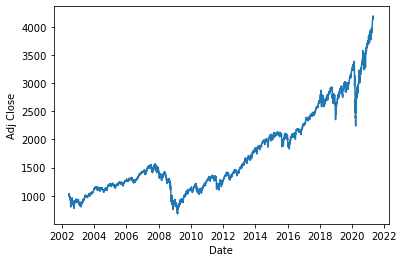

In [12]:
sns.lineplot(data=sp500, x="Date", y="Adj Close")

In [2]:
from contextlib import contextmanager
import sys, os

# This context is used to suppress output by redirecting it to null
# Some of the libraries used output verbose logs
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

### Market Model

Here, we implement the market model to predict the normal returns of the affect companies' stock price. 

The normal returns are the returns of a stock that would have happened without the breach. This market model consists of a regression with the following form:
$$r_{i,t} = \alpha_i + \beta_i * r_{m,t} + \epsilon_{i,t}$$

where $r_{i,t}$ is firm $i$'s normal return and $r_{m,t}$ is the actual market return. $\alpha_i$ and $\beta_i$ are the linear constant and coefficient, respectively, and $\epsilon_{i,t}$ is the regression error term. Our time increments are done by business days, so if the date of breach, $t=0$, is 4/23/2021 (Friday), then $t=1$ would be 4/26/21 (Monday). We then use this model to estimate $NR_{i,t}$, using $ \alpha_i + \beta_i * r_{m,t}$

Our market model estimates, which describes the daily percentage changes in stock price. To measure the the full impact of a breach, we need to collect these percentage changes over a period. We track the Cumulative Average Return (CAR) within +/- 7 business days of the breach. The $CAR_i(a,b)$ is defined as the following:

$$CAR_i(a,b) = \sum_{t=a}^{b}{AR_{i,t}}$$

For small intervals, the CAR serves as a good aggregate of abnormal returns. For longer intervals, the abnormal returns would compound, causing the real stock price to differ from the cumulative returns.

In [14]:
def window_date(date: datetime.datetime, window=(0, 0), business=True):
    if business:
        return (
            date + BDay(window[0]), 
            date + BDay(window[1])
        )
    return (
        date + pd.to_timedelta(window[0], unit="D"), 
        date + pd.to_timedelta(window[1], unit="D")
    )

def date_range(df, window_dates: Tuple[datetime.datetime, datetime.datetime]):
    return df.loc[(df.index >= window_dates[0]) & (df.index <= window_dates[1])]

def market_model(stock, sp500, window_date):
    # Normal Model Estimation
    window_sp500 = date_range(sp500, window_date)
    window_stock = date_range(stock, window_date)
    
    # pct_change - first entry is always nan
    sp500_returns = window_sp500["Adj Close"].pct_change()[1:].values.reshape(-1, 1) # "X"
    stock_returns = window_stock["Adj Close"].pct_change()[1:].values.reshape(-1, 1) # "Y"
    
    joined = pd.DataFrame({
        "sp500": window_sp500["Adj Close"], 
        "stock": window_stock["Adj Close"], 
    })
    if joined.isnull().values.any():
        print("Missing values for regression")
        
    joined = joined.dropna()
    
    if len(joined) == 0:
        raise ValueError("No stock values available. Ticker not available?")
        
    joined["sp500_returns"] = joined["sp500"].pct_change()
    joined["stock_returns"] = joined["stock"].pct_change()
    
    sp500_returns = joined["sp500_returns"].values[1:].reshape(-1, 1)
    stock_returns = joined["stock_returns"].values[1:].reshape(-1, 1)
    # Join the returns
    reg = LinearRegression()
    try:
        reg.fit(
            sp500_returns, 
            stock_returns
        )
        (alpha, beta) = reg.intercept_.item(), reg.coef_.item()
    except Exception as e:
#         print("<=========================== [Regression Error] ===========================>")
#         print(sp500_returns.shape)
#         print(stock_returns.shape)
#         print(joined.head())
#         print("<=========================== [Regression Error] ===========================>")
        raise ValueError("Model failed to fit")
    
    stock_returns_pred = reg.predict(sp500_returns)
    
    mse = mean_squared_error(stock_returns, stock_returns_pred)
    r2 = r2_score(stock_returns, stock_returns_pred)
    
    # Reformatted
    sp_ret = sp500_returns.ravel()
    st_ret = stock_returns.ravel()
    sp_ret = np.insert(sp_ret, 0, np.nan)
    st_ret = np.insert(st_ret, 0, np.nan)

    dat = pd.DataFrame({
        "sp500": window_sp500["Adj Close"], 
        "window_stock": window_stock["Adj Close"], 
        "sp500_returns": sp_ret,
        "stock_returns": st_ret,
    }, index=window_sp500["Adj Close"].index)
    
    return {
        "alpha": alpha,
        "beta": beta,
        "mse": mse,
        "r2": r2,
        "data": dat
    }


### Stock price retrieval

In this function, we use the specified estimation and event windows to retrieve the stock prices of interest for every company. We use `yfinance` library to retrieve stock prices by ticker and date from Yahoo Finance, a stock price database. After retrieving the relevant stock prices for a company, we execute. `market_model()` to find parameters alpha and beta. We cache the stock prices, markel parameters, normal returns and abnormal returns into a dictionary for every breach event. 

In [17]:
saves = {}

def normal_return_model(row, est_window=(-200, -7), event_window=(-7, 7), windows = [], coerce=True, debug=True):
    if est_window[0] > est_window[1] or event_window[0] > event_window[1]:
        raise ValueError("Invalid Window: Windows must be in form (a, b), a < b")
    if est_window[1] > event_window[0]:
        raise ValueError("Overlapping windows!")
        
    ticker = row["Ticker"]
    disclosure_date = row["Date of Disclosure"]
    
    # Convert windows to date windows
    est_window_date = window_date(disclosure_date, est_window)
    event_window_date = window_date(disclosure_date, event_window)
    
    start_date = est_window_date[0]
    end_date = event_window_date[1]
    
    # Ensure dates are valid
    today_date = datetime.date.today()
    if end_date > today_date:
        if coerce:
            end_date = today_date
        else:
            raise ValueError(
                f"Ending interval of {end_date.strftime('%Y-%m-%d')} is later than today {today_date.strftime('%Y-%m-%d')}"
            )
    
    if debug:
        print(f"Ticker: {row['Ticker']}")
        print(f"Date of Disclosure: {row['Date of Disclosure'].strftime('%Y-%m-%d')}")
        print(f"estimation window: {est_window_date}")
        print(f"event window: {event_window_date}")
    # Download
    
    try:
        with suppress_stdout():
            raw_prices = yf.download(ticker, start=start_date, end=end_date)
            
            
            raw_prices.dropna(axis = 0, how = 'all', inplace = True)
            if len(raw_prices) == 0:
                raise ValueError("Download Failed.")
    except Exception as e:
        raise ValueError('Download Failed.')
        
    # Linear Regression
    try:
        results = market_model(raw_prices, sp500, est_window_date)
        saves["results"] = results
        alpha, beta = results["alpha"], results["beta"]
    except Exception as e:
        raise ValueError('Model fit failed.')
        
    
    # Draw
    if debug:
        model_df = results["data"]
        saves["model_df"] = model_df
    
    # Event interval
    event_df = pd.DataFrame()
    event_df["actual"] = date_range(raw_prices, event_window_date)["Adj Close"].pct_change()[1:]
    event_df["sp500"] = date_range(sp500, event_window_date)["Adj Close"].pct_change()[1:]
    event_df["normal"] = alpha + beta * event_df["sp500"]
    event_df["abnormal"] = event_df["actual"] - event_df["normal"]
    
    # Compute CARs
    
    CAR = {}
    for w in windows:
        dates = window_date(disclosure_date, w)
        CAR[w] = date_range(event_df["abnormal"], dates).sum()
    return {
        "market_model": results,
        "event_df": event_df,
        "CAR": CAR,
    }

normal_return_model(df.iloc[0], windows = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)], debug=False)


{'market_model': {'alpha': -0.001284162345006583,
  'beta': 0.7296611253742332,
  'mse': 0.0002460786922381916,
  'r2': 0.2188656264703921,
  'data':                   sp500  window_stock  sp500_returns  stock_returns
  Date                                                               
  2020-05-21  2948.510010    392.742981            NaN            NaN
  2020-05-22  2955.449951    391.908356       0.002354      -0.002125
  2020-05-26  2991.770020    394.551361       0.012289       0.006744
  2020-05-27  3036.129883    396.786987       0.014827       0.005666
  2020-05-28  3029.729980    401.228424      -0.002108       0.011194
  ...                 ...           ...            ...            ...
  2021-02-09  3911.229980    381.960236      -0.001114       0.011233
  2021-02-10  3909.879883    377.377808      -0.000345      -0.011997
  2021-02-11  3916.379883    380.562561       0.001662       0.008439
  2021-02-12  3934.830078    380.013458       0.004711      -0.001443
  2021-02-16

We execute the `normal_return_model()`, which downloads and runs the market model regression, over all companies in the breach database. For some stocks, our downloader might fail because the ticker is malformed or because our stock database (yahoo finance) might not have the stock. 

In [19]:
import traceback

CARs = []
windows = [(0, i) for i in range(5)]
windows.extend([(-i, 0) for i in range(5)])
windows.extend([(-i, i) for i in range(5)])
print(windows)
arr = []
raw_results = []
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    try:
        result = normal_return_model(row, windows = windows, debug=False)
        car = result['CAR']
        obj = {
            'alpha': result['market_model']['alpha'],
            'beta': result['market_model']['beta']
        }
        obj.update({f'CAR{k}': v for k, v in car.items()})
        arr.append(obj)
        raw_results.append(result)
    except Exception as e:
#         print("<=============== Error ===============>")
#         print(f"Row #: {i}")
#         print(f"Ticker: {row['Ticker']}")
#         print("<================ End ================>")
#         traceback.print_exc()
        arr.append({})
        raw_results.append({})

assert len(arr) == len(df)
    



  0%|          | 0/737 [00:00<?, ?it/s]

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 0), (-1, 0), (-2, 0), (-3, 0), (-4, 0), (0, 0), (-1, 1), (-2, 2), (-3, 3), (-4, 4)]


  2%|▏         | 18/737 [00:03<02:30,  4.78it/s]

Missing values for regression


 11%|█         | 79/737 [00:17<02:40,  4.10it/s]

Missing values for regression


 15%|█▌        | 114/737 [00:26<01:59,  5.20it/s]

Missing values for regression


 53%|█████▎    | 389/737 [02:09<08:56,  1.54s/it]

Missing values for regression


 54%|█████▎    | 396/737 [02:14<04:44,  1.20it/s]

Missing values for regression


 80%|████████  | 591/737 [05:48<01:58,  1.23it/s]

Missing values for regression


 81%|████████  | 594/737 [05:50<01:34,  1.51it/s]

Missing values for regression


 85%|████████▍ | 626/737 [06:25<01:35,  1.16it/s]

Missing values for regression


 91%|█████████ | 667/737 [07:10<01:11,  1.03s/it]

Missing values for regression


 94%|█████████▍| 694/737 [07:42<00:45,  1.06s/it]

Missing values for regression


 95%|█████████▍| 699/737 [07:49<00:48,  1.27s/it]

Missing values for regression


 95%|█████████▍| 700/737 [07:50<00:40,  1.10s/it]

Missing values for regression


 97%|█████████▋| 718/737 [08:09<00:18,  1.01it/s]

Missing values for regression


100%|██████████| 737/737 [08:29<00:00,  1.45it/s]


After running this regression, we save the Cumulative Abnormal Returns (CAR) into a seperate csv file and pickle our auxillary data into `raw_results.pkl`. This serves as a good checkpoint, as downloading and running the regressions takes a substantial amount of time.

In [20]:
data_df = pd.DataFrame(arr)
data_df.head(50)
data_df.to_csv("../data/car_window_multi.csv")

In [24]:
import pickle
pkl_path = "../data/raw_results.pkl"

pickle.dump(raw_results, open(pkl_path , "wb"))

### Reloading the data


In [18]:
import pickle
pkl_path = "../data/raw_results.pkl"
raw_results = pickle.load(open(pkl_path , "rb"))

In [19]:
data_df = pd.read_csv("../data/stock_indicators.csv")

In [20]:
df = pd.read_csv("../data/car_window_multi.csv")

We join the results of the run back into our original dataframe (with company ticker and other related info)

In [21]:
df = pd.concat((df, data_df), axis=1)
df.head()

,Unnamed: 0,alpha,beta,"CAR(0, 0)","CAR(0, 1)","CAR(0, 2)","CAR(0, 3)","CAR(0, 4)","CAR(-1, 0)","CAR(-2, 0)","CAR(-3, 0)","CAR(-4, 0)","CAR(-1, 1)","CAR(-2, 2)","CAR(-3, 3)","CAR(-4, 4)",Unnamed: 0,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,count stock forecast,Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Forged Cookies (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),rootkit (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Mining (Industry),N/A (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),Foreign (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region)
0,0.0,-0.001284,0.729661,0.017022,0.019302,0.017108,0.027874,0.029140,0.018244,0.014400,0.029233,0.028117,0.020525,0.014486,0.040085,0.040235,0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1.0,0.000552,0.627575,0.004401,-0.005910,-0.005190,0.001705,-0.003996,-0.054406,-0.083507,-0.183648,-0.186695,-0.064717,-0.093099,-0.186345,-0.195093,1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaN,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2.0,0.003177,1.406970,-0.041744,-0.004872,-0.064055,-0.024123,0.032155,-0.082999,-0.033173,-0.074919,-0.089921,-0.046126,-0.055484,-0.057299,-0.016022,2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaN,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3.0,0.000393,0.006037,0.004938,-0.008048,-0.025120,-0.034058,-0.044685,-0.010849,0.009854,0.000922,0.000922,-0.023835,-0.020204,-0.038074,-0.048700,3,KROGER CO,KR,NaN,2021-01-23 00:00:00,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4.0,0.000799,1.244020,0.000000,0.007677,-0.010081,-0.001435,0.009003,-0.002613,-0.026126,-0.027469,-0.026339,0.005064,-0.036207,-0.028904,-0.017335,4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Individual Company Analysis

In this section, we analyze the financial impact of a particular breach, the SolarWinds breach, in detail. 

On December 14, 2020, SolarWinds publically announced that it experienced a major breach in its "Orion" system. Solarwinds is an information technology company that supplies software to major firms and government organizations. Through this breach, the actors were able to gain access to many organization's IT systems, allowing them to install further malware. Over 18,000 companies were affected - including Fortune 500 companies like Microsoft and government organizations like the Pentagon.

We plot the market model and the Cumulative Abnormal Returns (CAR) for Solarwind during this breach.

In [23]:
# Find indexes by company name (Equifax)
# df.index[df['Ticker'] == 'EFX']
np.where(df['Ticker'] == 'SWI')

# Equifax hack: 409
# Solarwinds: 43

(array([43]),)

In [373]:
raw_results[0].keys()

dict_keys(['market_model', 'event_df', 'CAR'])

In [374]:
result_df.head()

,Unnamed: 0,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,count stock forecast,Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Forged Cookies (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),rootkit (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Mining (Industry),N/A (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),Foreign (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region)
0,0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaT,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaT,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,KROGER CO,KR,NaN,2021-01-23,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [28]:
df.iloc[43].to_dict()

{'Unnamed: 0': 43,
 'alpha': 0.0004655641252782,
 'beta': 1.0417132941855325,
 'CAR(0, 0)': -0.1628033843666006,
 'CAR(0, 1)': -0.2562399554711582,
 'CAR(0, 2)': -0.2602133259154164,
 'CAR(0, 3)': -0.2905258718800476,
 'CAR(0, 4)': -0.4816520391182123,
 'CAR(-1, 0)': -0.1589699362794033,
 'CAR(-2, 0)': -0.1495057703652739,
 'CAR(-3, 0)': -0.1594120671368935,
 'CAR(-4, 0)': -0.150825417665077,
 'CAR(-1, 1)': -0.2524065073839608,
 'CAR(-2, 2)': -0.2469157119140897,
 'CAR(-3, 3)': -0.2871345546503404,
 'CAR(-4, 4)': -0.4696740724166887,
 'Company name': 'SolarWinds Corp',
 'Ticker': 'SWI',
 'Date of Breach': '3/2020 - 6/2020',
 'Date Became Aware of Breach': nan,
 'Date of Disclosure': '2020-12-14',
 'Number of Records': '18000',
 'Information': 'ND',
 'Stock Price (0 months DoD)': 19.6200008392334,
 'Stock Price (1 months DoD)': 14.640000343322754,
 'Stock Price (2 months DoD)': 17.040000915527344,
 'Stock Price (3 months DoD)': 16.81999969482422,
 'Stock Price (4 months DoD)': 18.049999

#### General Company Data

In [375]:
index = 43
# Need to match raw_results with table???
market_model_data = raw_results[index]["market_model"]
model_df = market_model_data["data"]
alpha = market_model_data["alpha"]
beta = market_model_data["beta"]

company_name = df.iloc[index]["Company name"]
company_ticker = df.iloc[index]["Ticker"]
breach_date = df.iloc[index]["Date of Disclosure"]
event_df = raw_results[index]["event_df"]

print(f"i:{index} > {company_name} ({company_ticker}), breach date: {breach_date.date()}")
print(f"Market Model: Y = {alpha:.3f} + {beta:.3f} * X")
model_df.head()


i:43 > SolarWinds Corp (SWI), breach date: 2020-12-14
Market Model: Y = 0.000 + 1.042 * X


,sp500,window_stock,sp500_returns,stock_returns
Date,,,,
2020-03-09,2746.560059,16.139999,NaN,NaN
2020-03-10,2882.229980,16.799999,0.049396,0.040892
2020-03-11,2741.379883,16.709999,-0.048868,-0.005357
2020-03-12,2480.639893,14.650000,-0.095113,-0.123279
2020-03-13,2711.020020,15.840000,0.092871,0.081229


#### Market Model Return History (Estimation)

Here, we compare the returns of SolarWinds alongside the S&P 500 index. The SolarWinds stock has higher variance than the S&P 500, as the S&P 500 is an aggregate over many different companies (and therefore diversified).


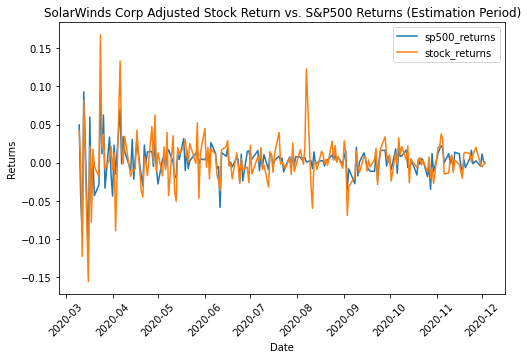

In [376]:
estimation_return = pd.melt(model_df[["sp500_returns", "stock_returns"]], ignore_index=False)
melted.head()

# filtered.tail(100)
plt.figure(figsize=(8,5))
ax = sns.lineplot(data=estimation_return, x=estimation_return.index, y="value", hue="variable")
ax.set_title(f"{company_name} Adjusted Stock Return vs. S&P500 Returns (Estimation Period)")
ax.set_ylabel("Returns")
plt.xticks(rotation=45)
ax.legend(loc=1)
plt.show()

Text(0.5, 0, 'S&P 500 Market Returns')

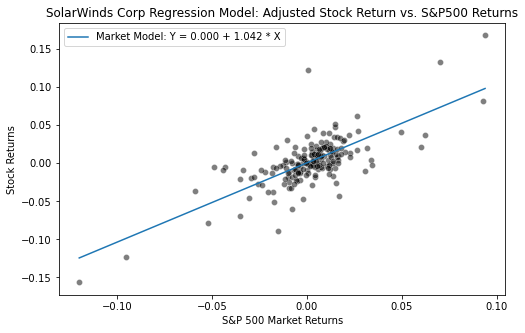

In [377]:
sp500_returns = model_df["sp500_returns"]
stock_returns = model_df["stock_returns"]

plt.figure(figsize=(8,5))
# Display regression line
X = sp500_returns.values
Y = alpha + beta * X
ax = sns.lineplot(x=X, y=Y, label=f'Market Model: Y = {alpha:.3f} + {beta:.3f} * X')
# ----------------------------
sns.scatterplot(data=model_df, x="sp500_returns", y="stock_returns", color="black", alpha=0.5)

ax.legend()
ax.set_title(f"{company_name} Regression Model: Adjusted Stock Return vs. S&P500 Returns")
ax.set_ylabel("Stock Returns")
ax.set_xlabel("S&P 500 Market Returns")

In this regression plot, we pair each day's S&P 500 return with SolarWind's return. The data satisfies most of linear regression's assumptions:

- The plot shows a clear linear relationship
- The residuals have mostly constant variance across all values
- The residuals are mostly normally distributed

For the independence assumption, which suggests that data points must be independent, may be slightly violated as stock returns are correlated with one another temporally. However, over a large window, these violations do not affect the model by much, and research into market models suggest that linear regression remains an effective tool for estimating normal returns.

#### Event Analysis

In [378]:
diff = (pd.Series(event_df.index - breach_date, index = event_df.index))
event_df["day_diff"] = diff
event_df.head()

,actual,sp500,normal,abnormal,day_diff
Date,,,,,
2020-12-04,0.022477,0.008836,0.009670,0.012806,-10 days
2020-12-07,0.009483,-0.001936,-0.001551,0.011034,-7 days
2020-12-08,0.011956,0.002787,0.003369,0.008587,-6 days
2020-12-09,-0.017722,-0.007949,-0.007815,-0.009906,-5 days
2020-12-10,0.008591,-0.001285,-0.000873,0.009464,-4 days


In [379]:
plt.figure(figsize=(8,5))
event_return = pd.melt(event_df[['sp500', 'actual']], ignore_index=False)


<Figure size 576x360 with 0 Axes>

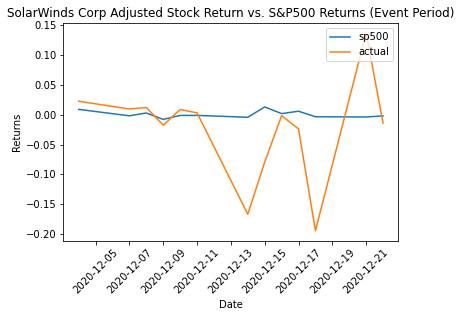

In [380]:
ax = sns.lineplot(data=event_return, x=event_return.index, y="value", hue="variable")
ax.set_title(f"{company_name} Adjusted Stock Return vs. S&P500 Returns (Event Period)")
ax.set_ylabel("Returns")
plt.xticks(rotation=45)
ax.legend(loc=1)
plt.show()

In this plot, we notice a substantial deviation in stock price proceeding the breach event. The company's stock price stopped over `15%` in two of the event window days. The S&P500 index remained stable across the week.

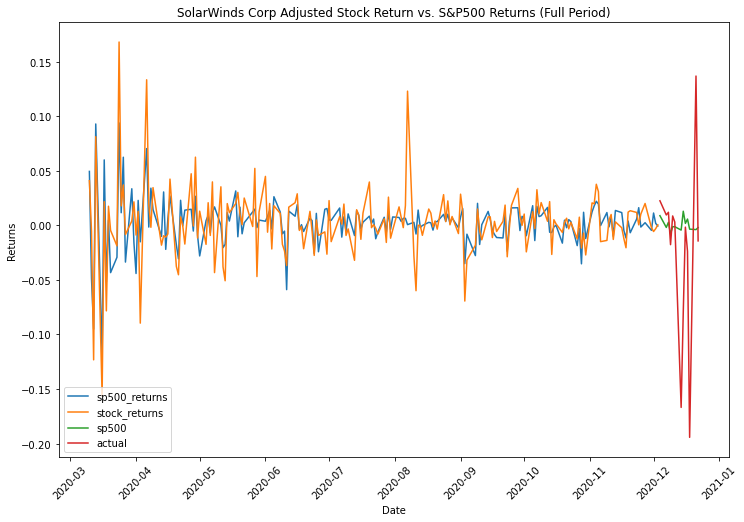

In [381]:
f = pd.concat([estimation_return, event_return], axis=0)

plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=f, x=f.index, y="value", hue="variable")
ax.set_title(f"{company_name} Adjusted Stock Return vs. S&P500 Returns (Full Period)")
ax.set_ylabel("Returns")
plt.xticks(rotation=45)
ax.legend(loc=3)
plt.show()

Here, we plot the S&P 500 and SolarWinds stock prices across the estimation **and** event window. Notice how the SolarWind's stock price deviated substantially from the S&P500 during this period. This serves as supporting evidence (but not sufficient) that it was the breach, and not market wide downturns, that caused this drop in stock price.

In [382]:
car_data = date_range(event_df, window_date(breach_date, CAR_range)) # Get the range of abnormal returns of interest
car_data.head()

,actual,sp500,normal,abnormal,day_diff
Date,,,,,
2020-12-14,-0.166879,-0.004359,-0.004076,-0.162803,0 days
2020-12-15,-0.079511,0.012921,0.013926,-0.093437,1 days
2020-12-16,-0.001661,0.001773,0.002312,-0.003973,2 days
2020-12-17,-0.023849,0.005758,0.006463,-0.030313,3 days
2020-12-18,-0.194318,-0.003511,-0.003192,-0.191126,4 days


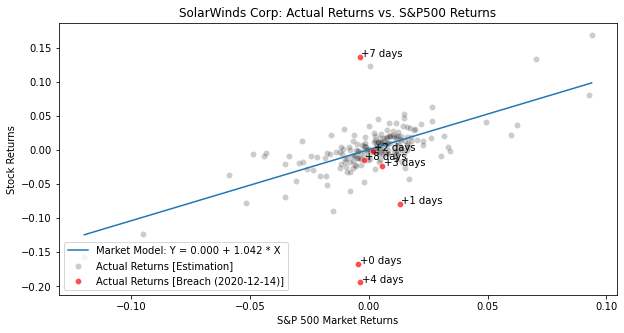

In [383]:
# Plotted with abnormal returns

plt.figure(figsize=(10,5))
ax = sns.lineplot(x=X, y=Y, label=f'Market Model: Y = {alpha:.3f} + {beta:.3f} * X')
sns.scatterplot(data=model_df, x="sp500_returns", y="stock_returns", color="black", alpha=0.2, label="Actual Returns [Estimation]")
sns.scatterplot(data=car_data, x="sp500", y="actual", color="red", alpha=0.7, label=f"Actual Returns [Breach ({breach_date.date()})]")
ax.legend(loc=3)
ax.set_title(f"{company_name}: Actual Returns vs. S&P500 Returns")
ax.set_ylabel("Stock Returns")
ax.set_xlabel("S&P 500 Market Returns")


for line in range(0,car_data.shape[0]):
     ax.text(car_data["sp500"][line] + 0.0005, car_data["actual"][line], 
     f"+{car_data['day_diff'][line].days} days", horizontalalignment='left', 
     size='medium', color='black')
        
plt.show()

In this plot, we impose the event window returns on our market model. Once again, we observe substantial deviations of SolarWind's stock price relative to our market model, which is based on the S&P 500.

### CAR Plots

Here, we analyze the Cumulative Abnormal Returns (CAR) over the entire database of breaches. We would like to detect whether there was a statistically signficant change in stock price after the breach.

In [126]:
data_df.describe()
# sns.histplot(data=data_df, x="CAR(0, 3)")

,alpha,beta,"CAR(0, 0)","CAR(0, 1)","CAR(0, 2)","CAR(0, 3)","CAR(0, 4)","CAR(-1, 0)","CAR(-2, 0)","CAR(-3, 0)","CAR(-4, 0)","CAR(-1, 1)","CAR(-2, 2)","CAR(-3, 3)","CAR(-4, 4)"
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.000053,1.023100,-0.002988,-0.005523,-0.005461,-0.005951,-0.005077,-0.003543,-0.005016,-0.006480,-0.005464,-0.006079,-0.007490,-0.009443,-0.007553
std,0.002481,0.406109,0.031683,0.051165,0.063268,0.076296,0.077086,0.051530,0.057690,0.067630,0.071852,0.067590,0.083621,0.100194,0.102354
min,-0.015719,-0.675626,-0.283234,-0.500287,-0.612629,-0.981688,-0.969539,-0.339825,-0.467816,-0.676899,-0.744292,-0.689882,-0.806871,-1.149207,-0.924367
25%,-0.000688,0.792516,-0.009730,-0.015455,-0.017480,-0.020186,-0.021391,-0.013725,-0.018967,-0.021282,-0.022933,-0.019143,-0.025747,-0.029474,-0.031421
50%,0.000077,1.012842,-0.001301,-0.001397,-0.001998,-0.001914,-0.000498,-0.001707,-0.002375,-0.002215,-0.003452,-0.001759,-0.002515,-0.003207,-0.004596
75%,0.000810,1.245130,0.006023,0.009438,0.013467,0.015015,0.019075,0.010556,0.010965,0.015660,0.016742,0.012224,0.016889,0.021759,0.027082
max,0.045698,2.803848,0.178117,0.315104,0.568382,0.786172,0.602221,0.833082,0.864915,0.914935,0.908253,0.744021,0.883055,0.933075,0.859731


In [209]:
data_df.head()
data_df.columns

Index(['alpha', 'beta', 'CAR(0, 0)', 'CAR(0, 1)', 'CAR(0, 2)', 'CAR(0, 3)',
       'CAR(0, 4)', 'CAR(-1, 0)', 'CAR(-2, 0)', 'CAR(-3, 0)', 'CAR(-4, 0)',
       'CAR(-1, 1)', 'CAR(-2, 2)', 'CAR(-3, 3)', 'CAR(-4, 4)'],
      dtype='object')

In [210]:
post_car_columns = ['CAR(0, 0)', 'CAR(0, 1)', 'CAR(0, 2)', 'CAR(0, 3)', 'CAR(0, 4)']
pre_car_columns = ['CAR(-1, 0)', 'CAR(-2, 0)', 'CAR(-3, 0)', 'CAR(-4, 0)']
wide_car_columns = ['CAR(-1, 1)', 'CAR(-2, 2)', 'CAR(-3, 3)', 'CAR(-4, 4)']
post_car = data_df[post_car_columns]
pre_car = data_df[pre_car_columns]
wide_car = data_df[wide_car_columns]

<Figure size 432x360 with 0 Axes>

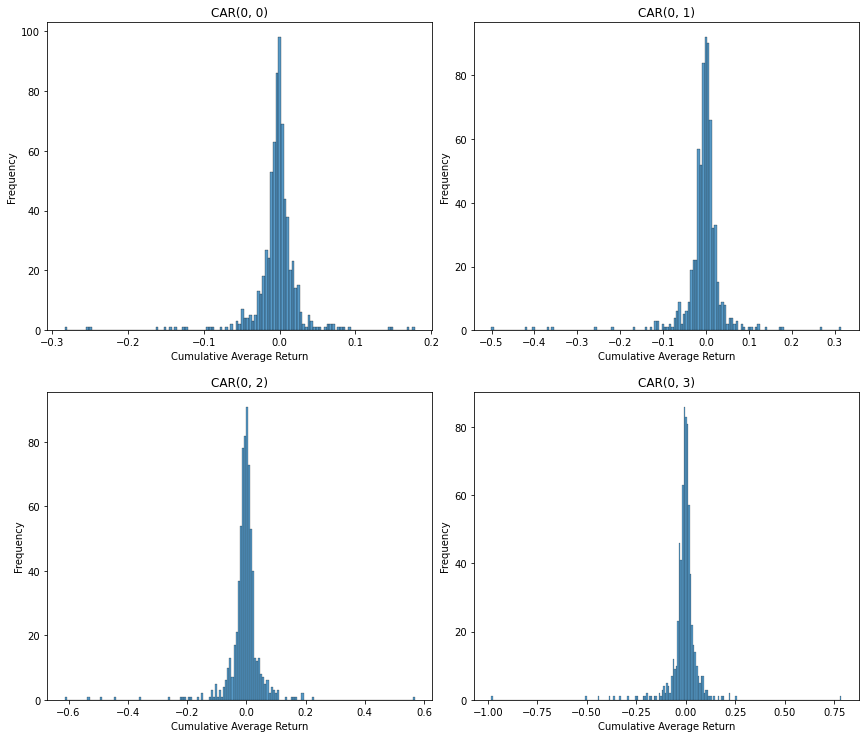

In [364]:
plt.figure(figsize=(6,5))

A = 2
B = 2
fig, axs = plt.subplots(A, B, figsize=(6 * A, 5 * B))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
for ax, col in zip(axs.flat, post_car_columns):
    ax = sns.histplot(data_df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Cumulative Average Return")
    ax.set_ylabel("Frequency")
plt.show()

The cumulative returns over different date windows follows a normal distribution. Based on these histograms, there is a slight shift of the Cumulative Average Returns towards the negative. 

In [394]:
import scipy
f = pd.DataFrame({name: scipy.stats.ttest_1samp(data.dropna().values, 0) for (name, data) in post_car.iteritems()})
f.insert(0, 'Description', ["t-statistic", "p-value"])
print(f.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  Description &  CAR(0, 0) &  CAR(0, 1) &  CAR(0, 2) &  CAR(0, 3) &  CAR(0, 4) \\
\midrule
0 &  t-statistic &  -2.496676 &  -2.858065 &  -2.285445 &  -2.065081 &  -1.743648 \\
1 &      p-value &   0.012765 &   0.004389 &   0.022585 &   0.039283 &   0.081659 \\
\bottomrule
\end{tabular}



In [234]:
{name: scipy.stats.ttest_1samp(data.dropna().values, 0) for (name, data) in post_car.iteritems()}

{'CAR(0, 0)': Ttest_1sampResult(statistic=-2.4966763846105864, pvalue=0.012765110304080349),
 'CAR(0, 1)': Ttest_1sampResult(statistic=-2.8580654163502506, pvalue=0.004388953890536081),
 'CAR(0, 2)': Ttest_1sampResult(statistic=-2.285444653004651, pvalue=0.0225849026795037),
 'CAR(0, 3)': Ttest_1sampResult(statistic=-2.0650810416001937, pvalue=0.03928298728076561),
 'CAR(0, 4)': Ttest_1sampResult(statistic=-1.7436480736939275, pvalue=0.08165947977566047)}

The t-tests of the CARs across the (0, 0) to (0, 4) windows suggests that the deviations are statistically significant. Four of the five windows show a p-value that is under an alpha of 5%. This supports our initial hypothesis that breaches would negatively affect a company's returns. 